In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

# Load data

In [2]:
df_train = pd.read_csv('data/titanic_train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data analysis

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


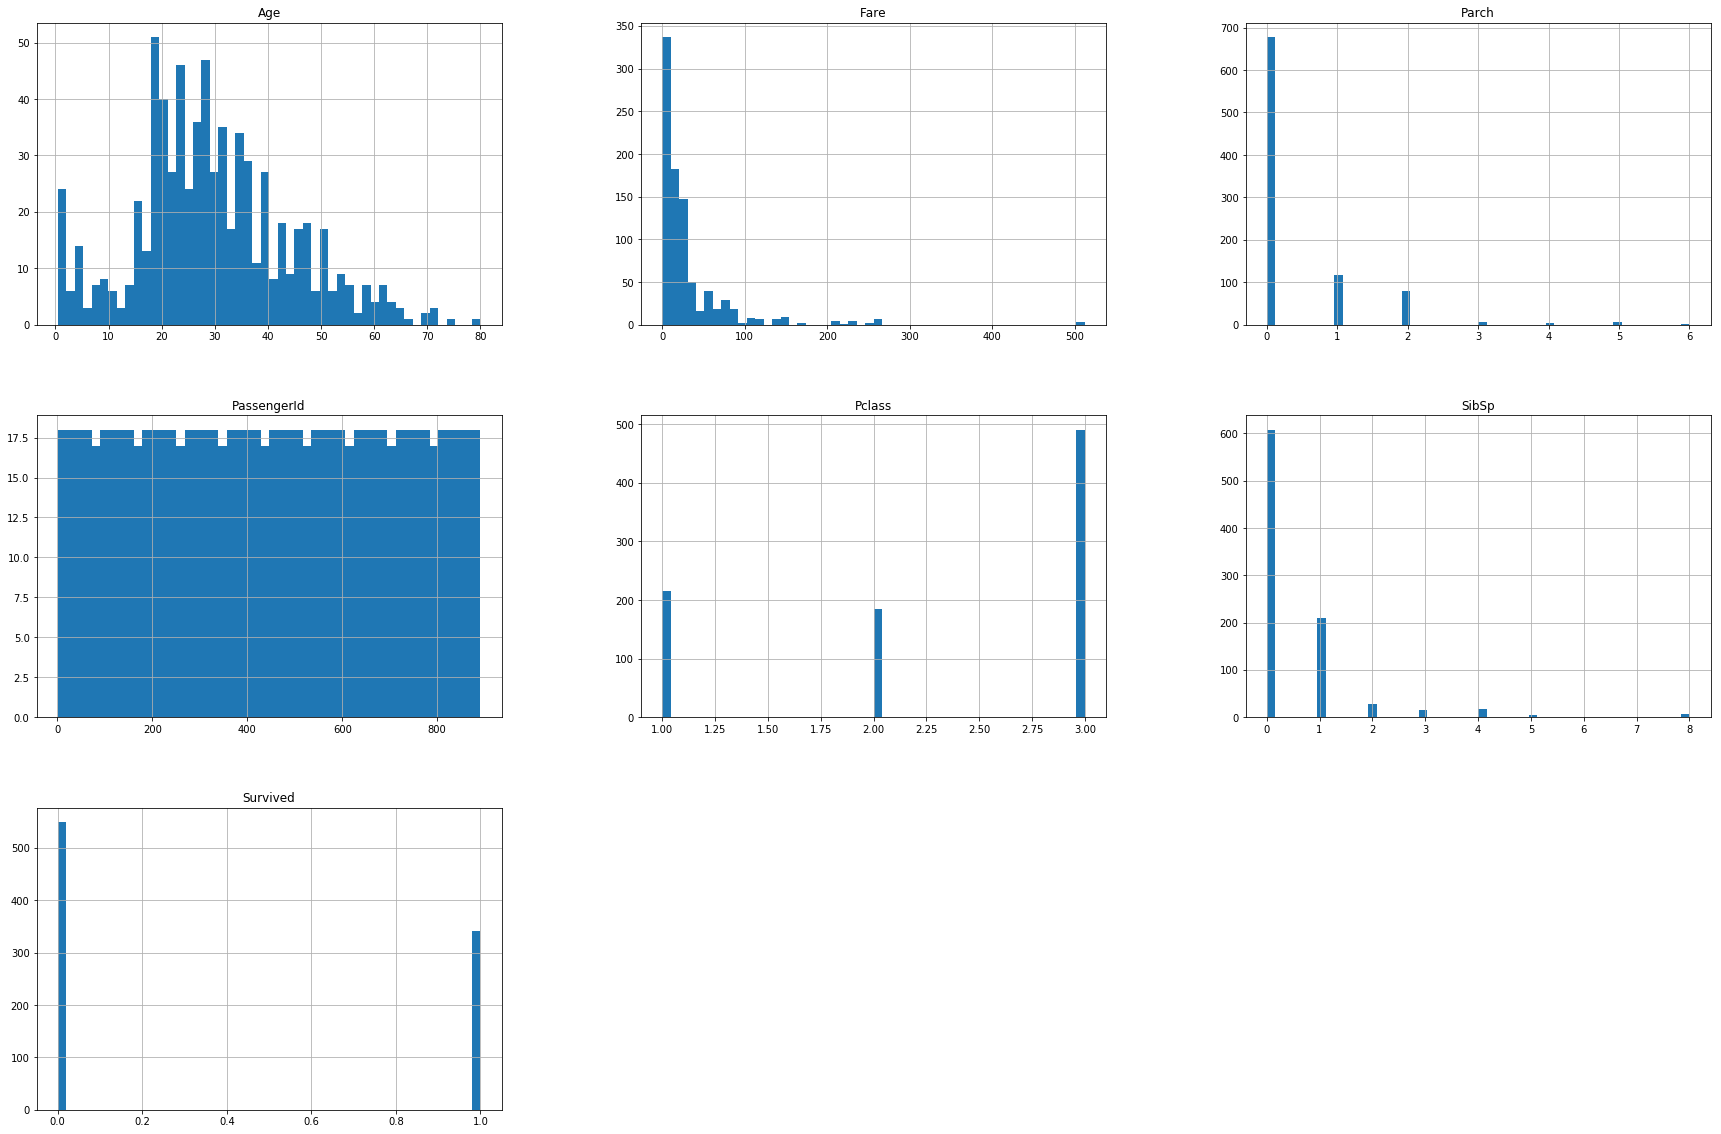

In [5]:
df_train.hist(bins=50, figsize=(30, 20));

In [6]:
# check for a correlation
corr_matrix = df_train.corr()

corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

# Preparing data

In [7]:
# clear the data
y_train = df_train['Survived']
X_train = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [8]:
numerical_attributs = ['Age', 'SibSp', 'Parch',  'Fare']
categorical_attributs = ['Pclass', 'Sex', 'Embarked']

In [9]:
# create Pipelines

class DataFrameSelector(BaseEstimator, TransformerMixin):
    """Class from book Handson-ml by Ayrelien Geron. This estimators
    takes chosen columns from dataframe"""
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [10]:
numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical_attributs)),
    ('in=mupter', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

In [14]:
categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attributs)),
    ('in=mupter', SimpleImputer(strategy="most_frequent")),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [15]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', numerical_pipeline),
    ('cat_pipeline', categorical_pipeline)
])

In [16]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [19]:
X_train.values

array([[3, 'male', 22.0, ..., 0, 7.25, 'S'],
       [1, 'female', 38.0, ..., 0, 71.2833, 'C'],
       [3, 'female', 26.0, ..., 0, 7.925, 'S'],
       ...,
       [3, 'female', nan, ..., 2, 23.45, 'S'],
       [1, 'male', 26.0, ..., 0, 30.0, 'C'],
       [3, 'male', 32.0, ..., 0, 7.75, 'Q']], dtype=object)

In [20]:
X_train_prepared

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

# Test different models with cross validation and choose the best one.

In [42]:
#sgd classifier 
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=3)

array([0.77104377, 0.77441077, 0.79124579])

In [40]:
knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, X_train_prepared, y_train, cv=3)

array([0.77104377, 0.79124579, 0.8047138 ])

In [44]:
#Linear Support vector machine algorithm
linear_svm_clf = LinearSVC(random_state=42, max_iter=10000)
cross_val_score(linear_svm_clf, X_train_prepared, y_train, cv=3)

array([0.79124579, 0.79124579, 0.78451178])

In [45]:
#Polynomial Support vector machine algorithm
poly_svm_clf = SVC(kernel='rbf', random_state=42, gamma='scale')
cross_val_score(poly_svm_clf, X_train_prepared, y_train, cv=3)

array([0.81144781, 0.84175084, 0.83501684])

In [53]:
#Random foresc classifier with random parameters
random_forest = RandomForestClassifier(n_estimators=200, max_leaf_nodes=2)
cross_val_score(random_forest, X_train_prepared, y_train, cv=3)

array([0.75420875, 0.8013468 , 0.77104377])

SVM with polynomial kernel turned out the best so now it is time to use gridSearch on it

In [63]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'coef0': [0.1, 0.01, 0.001, 0.0001], 'degree': [2, 3, 4, 5], 'kernel': ['poly']}
 ]

svm_gridSearch = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

In [64]:
svm_gridSearch.fit(X_train_prepared, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}, {'C': [0.1, 1, 10, 100, 1000], 'coef0': [0.1, 0.01, 0.001, 0.0001], 'degree': [2, 3, 4, 5], 'kernel': ['poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [65]:
svm_gridSearch.best_score_

0.8294051627384961

In [66]:
svm_gridSearch.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
svm_gridSearch.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

# Fit the best algorithm to training data and predict test data

In [71]:
best_model = SVC(C=100, gamma=0.01, kernel='rbf')
best_model.fit(X_train_prepared, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
y_pred = best_model.predict(X_train_prepared)
confusion_matrix(y_train, y_pred)

array([[497,  52],
       [ 96, 246]], dtype=int64)

In [75]:
accuracy_score(y_train, y_pred)

0.8338945005611672

In [76]:
X_test = pd.read_csv('data/titanic_test.csv')
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [78]:
X_test_prepared = full_pipeline.fit_transform(X_test)

In [79]:
y_test = best_model.predict(X_test_prepared)

In [80]:
y_test

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [84]:
passenger = X_test['PassengerId'].values

In [88]:
result_df = pd.DataFrame({'PassengerId' :passenger,
                          'Survived': y_test})

In [89]:
result_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [91]:
result_df.to_csv('result29-5-2019.csv', index=False)

Score in kaggle:
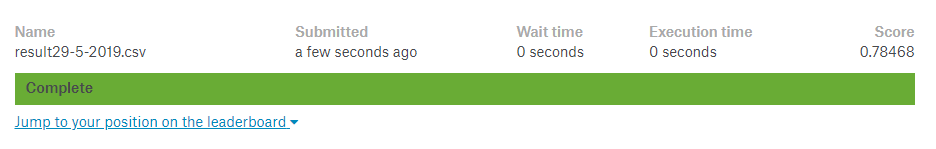